Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import gensim
from sklearn.decomposition import PCA

In [2]:
# references URL : https://www.kaggle.com/rinnqd/reduce-memory-usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
#!pip install -U spacy==1.9.0

In [ ]:
!python -m spacy download en_vectors_glove_md



    100% |████████████████████████████████| 762.3MB 84.8MB/s 

    Linking successful

    /usr/local/lib/python3.6/dist-packages/en_vectors_glove_md/en_vectors_glove_md-1.0.0
    -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_vectors_glove_md

    You can now load the model via spacy.load('en_vectors_glove_md').



READING CSV FILE

In [5]:
order_products_prior_data = pd.read_csv("/content/drive/MyDrive/instcart/six file/order_products__prior.csv")
order_products_train_data = pd.read_csv("/content/drive/MyDrive/instcart/six file/order_products__train.csv")
orders_data= pd.read_csv("/content/drive/MyDrive/instcart/six file/orders.csv")

In [ ]:
product_data = pd.read_csv("/content/drive/MyDrive/instcart/six file/products.csv")
aisles_data= pd.read_csv("/content/drive/MyDrive/instcart/six file/aisles.csv")
departments_data=pd.read_csv("/content/drive/MyDrive/instcart/six file/departments.csv")

MERGE  DATA

In [ ]:
prior_data= orders_data.merge(order_products_prior_data, on='order_id', how='inner').merge(product_data,on='product_id',how='left').merge(aisles_data,on='aisle_id',how='left')
prior_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks
1,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree
2,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky
3,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods


In [ ]:
prior_data=reduce_mem_usage(prior_data)

Memory usage after optimization is: 1701.26 MB
Decreased by 54.2%


# CREATE FEATURES FOR USERS

->TOTAL NUMBER OF ORDER GIVEN BY EACH USER:

As we saw in eda user's give orders between 4 to 100 .So , if there is high number of order than user reordered many products.

In [ ]:
total_no_of_order_by_user=prior_data.groupby(by='user_id')['order_number'].max().to_frame('total_no_of_order_by_user').reset_index()
print(total_no_of_order_by_user.shape)
total_no_of_order_by_user.head()

(206209, 2)


,user_id,total_no_of_order_by_user
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


->TOTAL NUMBER OF PRODUCTS PURCHASED BY EACH USER:

If user total number of purchased products are high than there is high probability of reordered of products.

In [ ]:
total_no_of_items = prior_data.groupby(by="user_id")["product_id"].count().to_frame("total_no_of_items").reset_index()
total_no_of_items.head()

,user_id,total_no_of_items
0,1,59
1,2,195
2,3,88
3,4,18
4,5,37


TOTAL NUMBER OF UNIQUE ITEM BY EACH USER

In [ ]:
total_no_of_unique_items = prior_data.groupby(by="user_id")["product_id"].nunique().to_frame("total_no_of_unique_items").reset_index()
total_no_of_unique_items.head()

,user_id,total_no_of_unique_items
0,1,18
1,2,102
2,3,33
3,4,17
4,5,23


AVERAGE PRODUCT IN ORDER BY USER

In [ ]:
avg_product_in_order_by_user=pd.merge(total_no_of_order_by_user,total_no_of_items,on="user_id" , how="left")
avg_product_in_order_by_user['avg_product_in_order_by_user']=avg_product_in_order_by_user['total_no_of_items']/avg_product_in_order_by_user['total_no_of_order_by_user']
avg_product_in_order_by_user.head()

,user_id,total_no_of_order_by_user,total_no_of_items,avg_product_in_order_by_user
0,1,10,59,5.900000
1,2,14,195,13.928571
2,3,12,88,7.333333
3,4,5,18,3.600000
4,5,4,37,9.250000


In [ ]:
avg_product_in_order_by_user.drop(['total_no_of_order_by_user', 'total_no_of_items'], axis=1,inplace=True)
avg_product_in_order_by_user.head()

,user_id,avg_product_in_order_by_user
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


NUMBER OF REORDERS BY EACH USER

In [ ]:
num_reorders_by_user = prior_data.groupby(by="user_id")["reordered"].sum().to_frame("num_reorders_by_user").reset_index()
num_reorders_by_user.head()

,user_id,num_reorders_by_user
0,1,41.0
1,2,93.0
2,3,55.0
3,4,1.0
4,5,14.0


NUMBER OF REORDERED MEAN BY USER

In [ ]:
reordered_mean_user = prior_data.groupby(by="user_id")["reordered"].mean().to_frame("reordered_mean_user").reset_index()
reordered_mean_user.head()

,user_id,reordered_mean_user
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


->MEAN OF USER DAY OF WEEK:

As we saw in eda there are more orders on day 0 and 1 and also high reordered in these days.

In [ ]:
user_dow_mean = prior_data.groupby(by="user_id")["order_dow"].mean().to_frame("user_dow_mean").reset_index()
user_dow_mean.head()

,user_id,user_dow_mean
0,1,2.644068
1,2,2.005128
2,3,1.011364
3,4,4.722222
4,5,1.621622


MEAN OF USER HOUR OF DAY:

As we saw in EDA user's purchased most orders between 8 to 18 hours and also reordered in these hours.

In [ ]:
user_hod_mean = prior_data.groupby(by="user_id")["order_hour_of_day"].mean().to_frame("user_hod_mean").reset_index()
user_hod_mean.head()

,user_id,user_hod_mean
0,1,10.542373
1,2,10.441026
2,3,16.352273
3,4,13.111111
4,5,15.729730


MEAN OF USER DAY SINCE PRIOR ORDERS:

As we saw in eda user generally prefer shopping weekly and monthly basis after there last order.

In [ ]:
user_dsp_mean = prior_data.groupby(by="user_id")["days_since_prior_order"].mean().to_frame("user_dsp_mean").reset_index()
user_dsp_mean.head()

,user_id,user_dsp_mean
0,1,20.265625
1,2,15.968750
2,3,11.484375
3,4,15.359375
4,5,14.500000


ON WHICH DAY USER PURCHASE MAX PRODUCT

In [ ]:
user_max_order_day = prior_data.groupby(by=['user_id'])['order_dow'].aggregate(lambda x : stats.mode(x)[0]).to_frame('user_max_order_day').reset_index()
user_max_order_day.head()

,user_id,user_max_order_day
0,1,4
1,2,2
2,3,0
3,4,4
4,5,3


ON WHICH HOUR USER PURCHASE MAX PRODUCT

In [ ]:
user_max_hod= prior_data.groupby(by=['user_id'])['order_hour_of_day'].aggregate(lambda x : stats.mode(x)[0]).to_frame('user_max_hod').reset_index()
user_max_hod.head()

,user_id,user_max_hod
0,1,7
1,2,9
2,3,16
3,4,15
4,5,18


TOTAL NO OF UNIQUE AISLE BY USER

In [ ]:
total_unique_aisle_by_user=prior_data.groupby(by=['user_id'])['aisle_id'].nunique().to_frame('total_unique_aisle_by_user').reset_index()
total_unique_aisle_by_user.head()

,user_id,total_unique_aisle_by_user
0,1,12
1,2,33
2,3,16
3,4,14
4,5,16


CONCATINATING ALL USER FEATURES

In [ ]:
user_features=[total_no_of_order_by_user,total_no_of_items,total_no_of_unique_items,
                  avg_product_in_order_by_user,num_reorders_by_user,reordered_mean_user,
                  user_dow_mean,user_hod_mean ,user_dsp_mean,user_max_order_day,user_max_hod,
                  total_unique_aisle_by_user]

In [ ]:
users = pd.DataFrame()
users["user_id"] = total_no_of_items.user_id.copy()
for f in user_features:
    users = pd.merge(users , f , on="user_id" , how="left")
users = reduce_mem_usage(users)

Memory usage after optimization is: 6.29 MB
Decreased by 62.4%


In [ ]:
pickle.dump(users,open('/content/drive/MyDrive/instcart/DATA2/users_features','wb'))

In [ ]:
del total_no_of_order_by_user,total_no_of_items,total_no_of_unique_items,avg_product_in_order_by_user,num_reorders_by_user,reordered_mean_user,user_dow_mean,user_hod_mean ,user_dsp_mean,user_max_order_day,user_max_hod,total_unique_aisle_by_user,user_features

In [ ]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206209 entries, 0 to 206208
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   user_id                       206209 non-null  int32  
 1   total_no_of_order_by_user     206209 non-null  int8   
 2   total_no_of_items             206209 non-null  int16  
 3   total_no_of_unique_items      206209 non-null  int16  
 4   avg_product_in_order_by_user  206209 non-null  float16
 5   num_reorders_by_user          206209 non-null  float16
 6   reordered_mean_user           206209 non-null  float16
 7   user_dow_mean                 206209 non-null  float16
 8   user_hod_mean                 206209 non-null  float16
 9   user_dsp_mean                 206209 non-null  float16
 10  user_max_order_day            206209 non-null  int8   
 11  user_max_hod                  206209 non-null  int8   
 12  total_unique_aisle_by_user    206209 non-nul

USER DAY OF WEEK REORDER RATIO

In [ ]:
user_dow= prior_data.groupby(['order_dow','user_id'])['reordered'].sum().reset_index()
user_dow.head()

,order_dow,user_id,reordered
0,0,3,37.0
1,0,5,4.0
2,0,7,53.0
3,0,9,4.0
4,0,11,0.0


In [ ]:
user_dow= user_dow.merge(num_reorders_by_user,on='user_id',how='left')
user_dow['user_dow_ratio'] = user_dow.reordered/user_dow.num_reorders_by_user
user_dow.head()

,order_dow,user_id,reordered,num_reorders_by_user,user_dow_ratio
0,0,3,37.0,55.0,0.672727
1,0,5,4.0,14.0,0.285714
2,0,7,53.0,138.0,0.384058
3,0,9,4.0,18.0,0.222222
4,0,11,0.0,33.0,0.000000


In [ ]:
user_dow = user_dow.drop(['reordered','num_reorders_by_user'],axis=1)
user_dow.head()

,order_dow,user_id,user_dow_ratio
0,0,3,0.672727
1,0,5,0.285714
2,0,7,0.384058
3,0,9,0.222222
4,0,11,0.000000


In [ ]:
pickle.dump(user_dow,open('/content/drive/MyDrive/instcart/DATA2/user_dow','wb'))

REORDER RATIO BY DOW

In [ ]:
dow_reorder_ratio=prior_data.groupby(by=['order_dow'])['reordered'].mean().to_frame('dow_reorder_ratio').reset_index()
dow_reorder_ratio.head()

,order_dow,dow_reorder_ratio
0,0,0.585276
1,1,0.603843
2,2,0.589771
3,3,0.586272
4,4,0.590979


In [ ]:
pickle.dump(dow_reorder_ratio,open('/content/drive/MyDrive/instcart/DATA2/dow_reorder_ratio','wb'))

HOD REORDER RATIO

In [ ]:
hod_reorder_ratio=prior_data.groupby(by=['order_hour_of_day'])['reordered'].mean().to_frame('hod_reorder_ratio').reset_index()
hod_reorder_ratio.head()

,order_hour_of_day,hod_reorder_ratio
0,0,0.565500
1,1,0.557114
2,2,0.554455
3,3,0.559498
4,4,0.571195


In [ ]:
pickle.dump(hod_reorder_ratio,open('/content/drive/MyDrive/instcart/DATA2/hod_reorder_ratio','wb'))

DSP REORDER RATIO

In [ ]:
prior_data['days_since_prior_order'].fillna(0,inplace=True)

In [ ]:
prior_data.isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
dtype: int64

In [ ]:
total_reorder=prior_data['reordered'].sum()

In [ ]:
dsp_reorder_ratio=prior_data.groupby(by=['days_since_prior_order'])['reordered'].agg('sum').to_frame('dsp_reorder_ratio').reset_index()
dsp_reorder_ratio['dsp_reorder_ratio']=dsp_reorder_ratio['dsp_reorder_ratio']/total_reorder
dsp_reorder_ratio.head()

,days_since_prior_order,dsp_reorder_ratio
0,0.0,0.017331
1,1.0,0.030390
2,2.0,0.049433
3,3.0,0.065646
4,4.0,0.073704


In [ ]:
pickle.dump(dsp_reorder_ratio,open('/content/drive/MyDrive/instcart/DATA2/dsp_reorder_ratio','wb'))

# PRODUCT FEATURES

HOW MANY UNIQUE USER PURCHASED PRODUCT:

As we saw in eda there are some products which purchased many times while some products purchased only few times.

In [ ]:
p_unique_users = prior_data.groupby(by="product_id")["user_id"].nunique().to_frame("p_unique_users").reset_index()
p_unique_users.head()

,product_id,p_unique_users
0,1,716
1,2,78
2,3,74
3,4,182
4,5,6


TOTAL TIME PRODUCT PURCHASED:

As we saw in eda some products like banana Banana, Bag of Organic Bananas , Organic Strawberries , Organic Baby Spinach , Organic Hass Avocado has purchased many times so if products highly purchased than it may be highly reordered.

In [ ]:
p_total_purchase = prior_data.groupby(["product_id"])["order_id"].count().to_frame("p_total_purchase").reset_index()
p_total_purchase.head()

,product_id,p_total_purchase
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


PRODUCT REORDERD SUM

In [ ]:
p_sum_reordered = prior_data.groupby(["product_id"])["reordered"].sum().to_frame("p_sum_reordered").reset_index()
p_sum_reordered.head()

,product_id,p_sum_reordered
0,1,1136.0
1,2,12.0
2,3,203.0
3,4,147.0
4,5,9.0


PRODUCT REORDERD MEAN

In [ ]:
p_mean_reordered = prior_data.groupby(["product_id"])["reordered"].mean().to_frame("p_mean_reordered").reset_index()
p_mean_reordered

,product_id,p_mean_reordered
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000
...,...,...
49672,49684,0.111111
49673,49685,0.122449
49674,49686,0.700000
49675,49687,0.461538


PRODUCT DAY OF WEEK MEAN

As we saw in EDA many products are highly reordered on day 0 and 1 .

In [ ]:
p_mean_dow = prior_data.groupby(["product_id"])["order_dow"].mean().to_frame("p_mean_dow").reset_index()
p_mean_dow.head()

,product_id,p_mean_dow
0,1,2.776458
1,2,2.922222
2,3,2.736462
3,4,2.683891
4,5,2.733333


PRODUCT HOUR OF DAYS MEAN

As we saw in EDA many products are highly reordered between 8 to 18 hours .

In [ ]:
p_mean_hod = prior_data.groupby(["product_id"])["order_hour_of_day"].mean().to_frame("p_mean_hod").reset_index()
p_mean_hod.head()

,product_id,p_mean_hod
0,1,13.238121
1,2,13.277778
2,3,12.104693
3,4,13.714286
4,5,10.666667


PRODUCT DAY SINCE PRIOR ORDER MEAN:

As we saw in EDA many products are reordered weekly and monthly basis.

In [ ]:
p_mean_dsp = prior_data.groupby(["product_id"])["days_since_prior_order"].mean().to_frame("p_mean_dsp").reset_index()
p_mean_dsp.head()

,product_id,p_mean_dsp
0,1,9.882812
1,2,10.132812
2,3,9.914062
3,4,12.945312
4,5,11.601562


PRODUCT ADD TO CART ORDER MEAN

In [ ]:
p_mean_cart = prior_data.groupby(["product_id"])["add_to_cart_order"].mean().to_frame("p_mean_cart").reset_index()
p_mean_cart.head()

,product_id,p_mean_cart
0,1,5.801836
1,2,9.888889
2,3,6.415162
3,4,9.507599
4,5,6.466667


PRODUCT DOW REORDER RATIO

In [ ]:
product_dow= prior_data.groupby(['order_dow','product_id'])['reordered'].sum().reset_index()
product_dow.head()

,order_dow,product_id,reordered
0,0,1,134.0
1,0,2,3.0
2,0,3,39.0
3,0,4,38.0
4,0,5,1.0


In [ ]:
product_dow= product_dow.merge(p_sum_reordered,on='product_id',how='left')
product_dow.head()

,order_dow,product_id,reordered,p_sum_reordered
0,0,1,134.0,1136.0
1,0,2,3.0,12.0
2,0,3,39.0,203.0
3,0,4,38.0,147.0
4,0,5,1.0,9.0


In [ ]:
product_dow['product_and_dow_ratio'] = product_dow.reordered/product_dow.p_sum_reordered
product_dow= product_dow.drop(['reordered','p_sum_reordered'],axis=1)
product_dow.head()

,order_dow,product_id,product_and_dow_ratio
0,0,1,0.117958
1,0,2,0.250000
2,0,3,0.192118
3,0,4,0.258503
4,0,5,0.111111


In [ ]:
pickle.dump(product_dow,open('/content/drive/MyDrive/instcart/DATA2/product_dow','wb'))

MERGE PRODUCT FEATURES

In [ ]:
product_features=[p_unique_users,p_total_purchase,p_sum_reordered ,
                  p_mean_reordered ,p_mean_dow, p_mean_hod ,
                  p_mean_dsp,p_mean_cart]

In [ ]:
len(product_features)

8

In [ ]:
products = pd.DataFrame()
products["product_id"] = p_unique_users.product_id.copy()
for f in product_features:
   products=pd.merge(products,f,how='left',on='product_id')   

In [ ]:
products.isnull().sum()

product_id          0
p_unique_users      0
p_total_purchase    0
p_sum_reordered     0
p_mean_reordered    0
p_mean_dow          0
p_mean_hod          0
p_mean_dsp          0
p_mean_cart         0
dtype: int64

In [ ]:
products=reduce_mem_usage(products)

Memory usage after optimization is: 1.61 MB
Decreased by 54.1%


In [ ]:
pickle.dump(products,open('/content/drive/MyDrive/instcart/DATA2/products_features','wb'))

In [ ]:
del product_features,p_unique_users,p_total_purchase,p_sum_reordered ,p_mean_reordered ,p_mean_dow, p_mean_hod ,p_mean_dsp,p_mean_cart

## USER-PRODUCT FEATURES

In [ ]:
#FIRST OF ALL HOW TABLE LOOK LIKE WHEN GROUPBY['USER_ID','PRODUCT_ID']

#for example user_id==1 and it purchased unique product of product_id   22,233,11,21,212
x=' ';
print('user_id'  , 'product_id')
print('1' ,7*x       ,  '22')
print( 10*x+  '233')
print( 10*x+  '11')
print( 10*x+  '21')
print( 10*x+  '212')

user_id product_id
1         22
          233
          11
          21
          212


FOR EACH USER NO OF TIME USER PURCHASED UNIQUE PRODUCT

In [ ]:
up_unique_orders_count = prior_data.groupby(["user_id","product_id"])["order_id"].count().to_frame("up_unique_orders_count").reset_index()
up_unique_orders_count =reduce_mem_usage(up_unique_orders_count)
up_unique_orders_count.head()

Memory usage after optimization is: 114.22 MB
Decreased by 62.5%


,user_id,product_id,up_unique_orders_count
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


MAX NUMBER OF TIME USER PURCHASED PRODUCT

In [ ]:
up_unique_orders_count['up_total_buy_max']=up_unique_orders_count.groupby(['user_id'])['up_unique_orders_count'].transform('max')
up_unique_orders_count.head()

,user_id,product_id,up_unique_orders_count,up_total_buy_max
0,1,196,10,10
1,1,10258,9,10
2,1,10326,1,10
3,1,12427,10,10
4,1,13032,3,10


->diffrence between (USER MAX ORDER NUMBER) and (USER PRODUCT MAX ORDER NUMBER)

up_orders_diff : user max order number - user-product max order number

user_max_order_no : max order given by uesr

up_max_order_no : for each user and for each unique product for that user max order number for that product

In [ ]:
user_max_order_no = prior_data.groupby(['user_id'])['order_number'].max().to_frame("user_max_order_no").reset_index()
up_max_order_no = prior_data.groupby(["user_id" , "product_id"])["order_number"].max().to_frame("up_max_order_no").reset_index()

up_orders_diff= pd.merge(up_max_order_no , user_max_order_no , on="user_id" , how = "left")
up_orders_diff["up_orders_diff"] = up_orders_diff["user_max_order_no"] - up_orders_diff["up_max_order_no"]

up_orders_diff = up_orders_diff[["user_id" , "product_id" ,"up_orders_diff"]]
up_orders_diff=reduce_mem_usage(up_orders_diff)
up_orders_diff.head()

Memory usage after optimization is: 215.75 MB
Decreased by 32.0%


,user_id,product_id,up_orders_diff
0,1,196,0
1,1,10258,0
2,1,10326,5
3,1,12427,0
4,1,13032,0


USER - PRODUCT ORDER RATIO

up_unique_orders_count : for each user_id and each product_id  count number of time user purchase that order

user_max_order_no      : for each user_id count max number of order

up_order_ratio         :user-product order ratio

In [ ]:
up_order_ratio= pd.merge(up_unique_orders_count , user_max_order_no   , on="user_id" , how="left")
up_order_ratio["up_order_ratio"] = up_order_ratio["up_unique_orders_count"] / up_order_ratio["user_max_order_no"]
up_order_ratio = up_order_ratio[["user_id" , "product_id" , "up_order_ratio"]]
up_order_ratio.head()

,user_id,product_id,up_order_ratio
0,1,196,1.0
1,1,10258,0.9
2,1,10326,0.1
3,1,12427,1.0
4,1,13032,0.3


USER - PRODUCT DAY OF WEEK MEAN

In [ ]:
up_mean_dow = prior_data.groupby(["user_id","product_id"])["order_dow"].mean().to_frame("up_mean_dow").reset_index()
up_mean_dow=reduce_mem_usage(up_mean_dow)
up_mean_dow.head()

Memory usage after optimization is: 126.91 MB
Decreased by 58.3%


,user_id,product_id,up_mean_dow
0,1,196,2.500000
1,1,10258,2.554688
2,1,10326,4.000000
3,1,12427,2.500000
4,1,13032,2.666016


USER - PRODUCT HOUR OF DAY MEAN

In [ ]:
up_mean_hod = prior_data.groupby(["user_id","product_id"])["order_hour_of_day"].mean().to_frame("up_mean_hod").reset_index()
up_mean_hod=reduce_mem_usage(up_mean_hod)
up_mean_hod.head()

Memory usage after optimization is: 126.91 MB
Decreased by 58.3%


,user_id,product_id,up_mean_hod
0,1,196,10.296875
1,1,10258,10.554688
2,1,10326,15.000000
3,1,12427,10.296875
4,1,13032,8.000000


USER - PRODUCT DAY SINCE PREVIOUS ORDER MEAN

In [ ]:
up_mean_dsp = prior_data.groupby(["user_id","product_id"])["days_since_prior_order"].mean().to_frame("up_mean_dsp").reset_index()
up_mean_dsp =reduce_mem_usage(up_mean_dsp)
up_mean_dsp.head()

Memory usage after optimization is: 126.91 MB
Decreased by 44.4%


,user_id,product_id,up_mean_dsp
0,1,196,17.593750
1,1,10258,19.562500
2,1,10326,28.000000
3,1,12427,17.593750
4,1,13032,21.671875


USER - PRODUCT ORDER NUMBER SUM

In [ ]:
up_sum_order_no = prior_data.groupby(["user_id","product_id"])["order_number"].sum().to_frame("up_sum_order_no").reset_index()
up_sum_order_no=reduce_mem_usage(up_sum_order_no)
up_sum_order_no.head()

Memory usage after optimization is: 126.91 MB
Decreased by 58.3%


,user_id,product_id,up_sum_order_no
0,1,196,55.0
1,1,10258,54.0
2,1,10326,5.0
3,1,12427,55.0
4,1,13032,19.0


USER PRODUCT ADD TO CART MEAN

In [ ]:
up_mean_cart = prior_data.groupby(["user_id","product_id"])["add_to_cart_order"].mean().to_frame("up_mean_cart").reset_index()
up_mean_cart=reduce_mem_usage(up_mean_cart)
up_mean_cart.head()

Memory usage after optimization is: 126.91 MB
Decreased by 58.3%


,user_id,product_id,up_mean_cart
0,1,196,1.400391
1,1,10258,3.333984
2,1,10326,5.000000
3,1,12427,3.300781
4,1,13032,6.332031


3 FEATURE BASED ON LAST 5 ORDERS

In [ ]:
#URL : https://www.kaggle.com/errolpereira/xgboost-with-feature-engineering
prior_data['order_number_from_last'] = prior_data.groupby(by=['user_id'])['order_number'].transform(max) - prior_data.order_number + 1
prior_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,order_number_from_last
0,2539329,1,prior,1,2,8,0.0,196,1,0,Soda,77,7,soft drinks,10
1,2539329,1,prior,1,2,8,0.0,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,10
2,2539329,1,prior,1,2,8,0.0,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,10
3,2539329,1,prior,1,2,8,0.0,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,10
4,2539329,1,prior,1,2,8,0.0,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,10


In [ ]:
last_5 = prior_data.loc[prior_data.order_number_from_last <= 5]
print(last_5.shape)
last_5.head()

(9863821, 15)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,order_number_from_last
29,3367565,1,prior,6,2,7,19.0,196,1,1,Soda,77,7,soft drinks,5
30,3367565,1,prior,6,2,7,19.0,12427,2,1,Original Beef Jerky,23,19,popcorn jerky,5
31,3367565,1,prior,6,2,7,19.0,10258,3,1,Pistachios,117,19,nuts seeds dried fruit,5
32,3367565,1,prior,6,2,7,19.0,25133,4,1,Organic String Cheese,21,16,packaged cheese,5
33,550135,1,prior,7,1,9,20.0,196,1,1,Soda,77,7,soft drinks,4


Chance_in_last_5:In last5 if USER A PURCHASE PRODUCT B FOR FIRST TIME

IN LAST=(5) THAN Chance_in_last_5=1

IN LAST-1 ORDER THAN Chance_in_last_5=2

IN LAST-2 ORDER THAN Chance_in_last_5=3

IN LAST-3 ORDER THAN Chance_in_last_5=4

IN LAST-4 ORDER THAN Chance_in_last_5=5

In [ ]:
chance_in_last_5= last_5.groupby(by=['user_id', 'product_id'])['order_number_from_last'].aggregate('max').to_frame('chance_in_last_5').reset_index()
chance_in_last_5.head()

,user_id,product_id,chance_in_last_5
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,4
4,1,25133,5


Last_5_count:IN LAST 5 ORDERS OF USER’S COUNT OF UNIQUE PRODUCT

In [ ]:
last_5 = last_5.groupby(by=['user_id', 'product_id'])['order_id'].count().to_frame('last_5_count').reset_index()
last_5.head()

,user_id,product_id,last_5_count
0,1,196,5
1,1,10258,5
2,1,12427,5
3,1,13032,2
4,1,25133,5


Last_5_ratio: Last_5_count/5

In [ ]:
last_5["last_5_ratio"] = last_5["last_5_count"] / 5
last_5.head()

,user_id,product_id,last_5_count,last_5_ratio
0,1,196,5,1.0
1,1,10258,5,1.0
2,1,12427,5,1.0
3,1,13032,2,0.4
4,1,25133,5,1.0


In [ ]:
last_5.shape

(6714245, 4)

In [ ]:
last_5=pd.merge(last_5,chance_in_last_5,on=['user_id','product_id'],how='left')
print(last_5.shape)
last_5.head()

(6714245, 5)


,user_id,product_id,last_5_count,last_5_ratio,chance_in_last_5
0,1,196,5,1.0,5
1,1,10258,5,1.0,5
2,1,12427,5,1.0,5
3,1,13032,2,0.4,4
4,1,25133,5,1.0,5


In [ ]:
last_5=reduce_mem_usage(last_5)

Memory usage after optimization is: 128.06 MB
Decreased by 51.2%


MERGE USER-PRODUCT FEATURES

In [ ]:
user_product_feature=[up_unique_orders_count,up_orders_diff,up_order_ratio,
                  up_mean_dow,up_mean_hod,up_mean_dsp,up_sum_order_no,up_mean_cart,
                  last_5]

In [ ]:
user_product = pd.DataFrame()
user_product["user_id"] = up_unique_orders_count.user_id.copy()
user_product["product_id"] = up_unique_orders_count.product_id.copy()

for f in user_product_feature:
    user_product = pd.merge(user_product , f , on = ['user_id', 'product_id'], how='left')
user_product=reduce_mem_usage(user_product)    

Memory usage after optimization is: 469.58 MB
Decreased by 32.7%


In [ ]:
user_product.isnull().sum()

user_id                         0
product_id                      0
up_unique_orders_count          0
up_total_buy_max                0
up_orders_diff                  0
up_order_ratio                  0
up_mean_dow                     0
up_mean_hod                     0
up_mean_dsp                     0
up_sum_order_no                 0
up_mean_cart                    0
last_5_count              6593708
last_5_ratio              6593708
chance_in_last_5          6593708
dtype: int64

In [ ]:
user_product.fillna(0 , inplace = True)

In [ ]:
pickle.dump(user_product,open('/content/drive/MyDrive/instcart/DATA2/user_product_features','wb'))

In [ ]:
del user_product_feature,up_unique_orders_count,up_orders_diff,up_order_ratio
del up_mean_dow,up_mean_hod,up_mean_dsp,up_sum_order_no,up_mean_cart, last_5

CONSIDER ORDER AS SENTENCES AND PRODUCT_ID  AS WORDS FOR W2V

REFERENCES: https://omarito.me/word2vec-product-recommendations/

In [ ]:
prior_data.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'aisle', 'order_number_from_last'],
      dtype='object')

In [ ]:
prior_data["product_id"] = prior_data["product_id"].astype(str)
order_products_train_data['product_id']=order_products_train_data['product_id'].astype(str)

In [ ]:
prior_products_of_order = prior_data.groupby("order_id").apply(lambda order: order['product_id'].tolist())
train_products_of_order= order_products_train_data.groupby("order_id").apply(lambda order: order['product_id'].tolist())

In [ ]:
prior_products_of_order[:5]

order_id
2    [33120, 28985, 9327, 45918, 30035, 17794, 4014...
3    [33754, 24838, 17704, 21903, 17668, 46667, 174...
4    [46842, 26434, 39758, 27761, 10054, 21351, 225...
5    [13176, 15005, 47329, 27966, 23909, 48370, 132...
6                                [40462, 15873, 41897]
dtype: object

In [ ]:
corpus= prior_products_of_order.append(train_products_of_order)
longest = np.max(corpus.apply(len))
corpus = corpus.values

In [ ]:
model = gensim.models.Word2Vec(corpus, size=5, window=longest, min_count=1, workers=4)

In [ ]:
vocab = list(model.wv.vocab.keys())
len(vocab)

49685

In [ ]:
embedding_matrix = np.zeros((49688, 5))
for i in range(1,49689):
    word=str(i)
    if word in model.wv.vocab:
        embedding_matrix[i-1] = model.wv[word]

In [ ]:
embedding_matrix[0]

array([-3.2707305 , -4.23859882, -7.87262249, -5.09702301,  4.52043629])

In [ ]:
order2vec_features=pd.DataFrame(embedding_matrix)
order2vec_features.columns=["orderw2v_%s"%j for j in range(5)]
order2vec_features["product_id"]=range(1,49689)
order2vec_features.head()

,orderw2v_0,orderw2v_1,orderw2v_2,orderw2v_3,orderw2v_4,product_id
0,-3.270730,-4.238599,-7.872622,-5.097023,4.520436,1
1,-0.666321,0.725049,-0.115846,1.051244,0.761189,2
2,-3.422789,-1.191119,-1.846767,1.291017,-2.449048,3
3,2.693610,0.544360,-1.204878,-7.898958,-1.671540,4
4,-0.012311,0.228953,-0.532021,-0.203010,0.320053,5


In [ ]:
pickle.dump((order2vec_features),open("/content/drive/MyDrive/instcart/DATA2/order2vec_features",'wb'))

## REPRSENTATION OF PRODUCT NAME,AISLES NAME AND DEPARTMENT  NAME IN W2V

 reference:https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/38120

In [ ]:
product_aisle_department=product_data.merge(aisles_data,on='aisle_id',how='left').merge(departments_data,on='department_id',how='left')

In [ ]:
product_aisle_department.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [ ]:
product_aisle_department['name'] = product_aisle_department.product_name+' '+product_aisle_department.aisle+' '+product_aisle_department.department
product_aisle_department.head()

,product_id,product_name,aisle_id,department_id,aisle,department,name
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,Chocolate Sandwich Cookies cookies cakes snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry,All-Seasons Salt spices seasonings pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,Robust Golden Unsweetened Oolong Tea tea bever...
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,Smart Ones Classic Favorites Mini Rigatoni Wit...
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,Green Chile Anytime Sauce marinades meat prepa...


In [ ]:
import spacy
model_for_product = spacy.load('en_vectors_glove_md')

In [ ]:
from tqdm import tqdm
product_name_reprsentation = []
for i in tqdm(product_aisle_department['name']):
    product_name_reprsentation.append(model_for_product(i).vector.tolist())

100%|██████████| 49688/49688 [00:05<00:00, 9076.07it/s]


In [ ]:
len(product_name_reprsentation[0])

300

apply pca for  dimensionality reduction

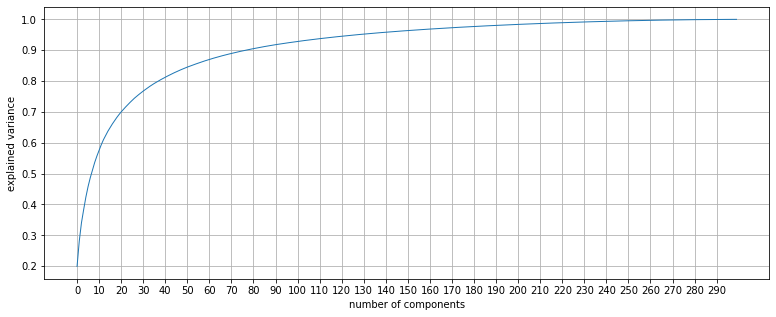

In [ ]:
pca_product = PCA(random_state=14)
pca_product.fit_transform(product_name_reprsentation)
percentage_var_explained = pca_product.explained_variance_ / np.sum(pca_product.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)
plt.figure(figsize=(13, 5))
plt.plot(cum_var_explained)
plt.grid()
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks([i for i in range(0,300,10)])
plt.show()

In this plot 35 components explain approximately 80% variance.

In [ ]:
pca_product.n_components = 35
pca_product_features = pca_product.fit_transform(product_name_reprsentation)
pca_product_features .shape

(49688, 35)

In [ ]:
pca_product_features= pd.DataFrame(pca_product_features)
pca_product_features.columns = ["pca_product"+str(i) for i in pca_product_features.columns]
pca_product_features['product_id'] = product_aisle_department.product_id
pca_product_features.head(5)

,pca_product0,pca_product1,pca_product2,pca_product3,pca_product4,pca_product5,pca_product6,pca_product7,pca_product8,pca_product9,pca_product10,pca_product11,pca_product12,pca_product13,pca_product14,pca_product15,pca_product16,pca_product17,pca_product18,pca_product19,pca_product20,pca_product21,pca_product22,pca_product23,pca_product24,pca_product25,pca_product26,pca_product27,pca_product28,pca_product29,pca_product30,pca_product31,pca_product32,pca_product33,pca_product34,product_id
0,-1.774349,1.862899,-1.726356,0.370522,-0.519996,-0.380709,0.096624,0.330845,-0.661177,0.241033,0.101181,-0.493973,-0.201572,-0.444850,0.419383,0.389619,-0.506580,0.202802,0.022298,0.002415,-0.327021,-0.023506,-0.280265,0.145873,-0.181585,-0.049066,0.415202,-0.019164,-0.204111,0.119044,0.003939,0.276257,-0.028392,-0.003242,-0.261290,1
1,-0.047741,-0.890461,0.513497,0.939047,-0.144349,0.227472,-0.158142,0.047917,-0.156420,-0.259751,-0.289473,0.887270,-0.114774,-0.213160,-0.354417,-0.099891,-0.329085,0.225002,0.126124,0.279918,0.041314,0.091101,-0.344999,-0.384182,-0.187571,0.083958,0.097627,-0.315279,0.045782,-0.019478,-0.137610,-0.261693,0.342441,-0.340478,0.108559,2
2,0.043657,1.457060,1.382342,0.071647,0.521699,-0.341240,-0.066442,0.399262,-0.172917,0.238910,0.056587,0.256850,0.346733,0.315623,0.158165,1.017319,0.347680,0.670804,0.007417,-0.133369,-0.014958,-0.134782,0.167031,0.027383,-0.363632,-0.447576,-0.384372,-0.071760,-0.104525,0.059152,-0.010457,0.062057,-0.232915,-0.030754,0.133745,3
3,-0.268130,-0.131417,-0.541702,-0.253781,0.678368,0.516824,-0.163390,-0.243593,-0.196065,-0.128423,0.031530,0.001493,0.142277,0.183941,0.257958,0.047451,-0.359922,-0.048906,-0.099979,0.176621,-0.216740,0.077760,0.010033,-0.054386,-0.023175,-0.147930,0.114699,-0.125601,0.014300,0.225421,-0.156754,-0.059309,-0.083742,0.053851,0.185819,4
4,-0.706677,-1.072866,0.284216,0.475295,0.321492,0.182623,-0.542613,0.310029,-0.340947,-0.090036,-0.179737,0.346138,-0.328105,-0.051831,-0.202492,-0.000895,-0.225905,-0.227601,-0.225100,-0.013339,-0.046565,-0.226341,0.077072,-0.005098,-0.087250,0.070884,0.037476,0.081641,-0.267840,-0.091839,0.029704,0.018115,0.151924,0.231747,-0.088788,5


In [ ]:
pickle.dump(pca_product_features,open("/content/drive/MyDrive/instcart/DATA2/pca_product_features",'wb'))

USER AISLE  FEATURES

In [ ]:
prior_data.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks
1,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree
2,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,popcorn jerky
3,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky
4,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods


In [ ]:
uais_unique_count = prior_data.groupby(["user_id","aisle_id"])["product_id"].count().to_frame("uais_unique_count").reset_index()
uais_unique_count =reduce_mem_usage(uais_unique_count)
uais_unique_count.head()

Memory usage after optimization is: 43.71 MB
Decreased by 66.7%


,user_id,aisle_id,uais_unique_count
0,1,21,8
1,1,23,12
2,1,24,5
3,1,45,1
4,1,53,2


In [ ]:
uais_reorder = prior_data.groupby(["user_id","aisle_id"])["reordered"].mean().to_frame("uais_reorder").reset_index()
uais_reorder=reduce_mem_usage(uais_reorder)
uais_reorder.head()

Memory usage after optimization is: 43.71 MB
Decreased by 66.7%


,user_id,aisle_id,uais_reorder
0,1,21,0.875000
1,1,23,0.833496
2,1,24,0.199951
3,1,45,0.000000
4,1,53,0.500000


In [ ]:
user_aisle_features=pd.merge(uais_unique_count,uais_reorder,on=['user_id','aisle_id'],how='left')
user_aisle_features.head()

,user_id,aisle_id,uais_unique_count,uais_reorder
0,1,21,8,0.875000
1,1,23,12,0.833496
2,1,24,5,0.199951
3,1,45,1,0.000000
4,1,53,2,0.500000


In [ ]:
pickle.dump(user_aisle_features,open('/content/drive/MyDrive/instcart/DATA2/user_aisle_features','wb'))

## MERGE ALL FEATURES

In [ ]:
users = pickle.load(open('/content/drive/MyDrive/instcart/DATA2/users_features','rb'))
print(users.shape)
users.head()

(206209, 13)


,user_id,total_no_of_order_by_user,total_no_of_items,total_no_of_unique_items,avg_product_in_order_by_user,num_reorders_by_user,reordered_mean_user,user_dow_mean,user_hod_mean,user_dsp_mean,user_max_order_day,user_max_hod,total_unique_aisle_by_user
0,1,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12
1,2,14,195,102,13.929688,93.0,0.476807,2.005859,10.437500,15.968750,2,9,33
2,3,12,88,33,7.332031,55.0,0.625000,1.011719,16.359375,11.484375,0,16,16
3,4,5,18,17,3.599609,1.0,0.055542,4.722656,13.109375,15.359375,4,15,14
4,5,4,37,23,9.250000,14.0,0.378418,1.622070,15.726562,14.500000,3,18,16


In [ ]:
products = pickle.load(open('/content/drive/MyDrive/instcart/DATA2/products_features','rb'))
print(products.shape)
products.head()

(49677, 9)


,product_id,p_unique_users,p_total_purchase,p_sum_reordered,p_mean_reordered,p_mean_dow,p_mean_hod,p_mean_dsp,p_mean_cart
0,1,716,1852,1136.0,0.613281,2.777344,13.234375,9.882812,5.800781
1,2,78,90,12.0,0.133301,2.921875,13.281250,10.132812,9.890625
2,3,74,277,203.0,0.732910,2.736328,12.101562,9.914062,6.414062
3,4,182,329,147.0,0.446777,2.683594,13.710938,12.945312,9.507812
4,5,6,15,9.0,0.600098,2.732422,10.664062,11.601562,6.464844


In [ ]:
user_products = pickle.load(open('/content/drive/MyDrive/instcart/DATA2/user_product_features','rb'))
print(user_products.shape)
user_products.head()

(13307953, 14)


,user_id,product_id,up_unique_orders_count,up_total_buy_max,up_orders_diff,up_order_ratio,up_mean_dow,up_mean_hod,up_mean_dsp,up_sum_order_no,up_mean_cart,last_5_count,last_5_ratio,chance_in_last_5
0,1,196,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,1.400391,5.0,1.000000,5.0
1,1,10258,9,10,0,0.899902,2.554688,10.554688,19.562500,54.0,3.333984,5.0,1.000000,5.0
2,1,10326,1,10,5,0.099976,4.000000,15.000000,28.000000,5.0,5.000000,0.0,0.000000,0.0
3,1,12427,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,3.300781,5.0,1.000000,5.0
4,1,13032,3,10,0,0.300049,2.666016,8.000000,21.671875,19.0,6.332031,2.0,0.399902,4.0


In [ ]:
pca_product_features= pickle.load(open('/content/drive/MyDrive/instcart/DATA2/pca_product_features','rb'))
print(pca_product_features.shape)
pca_product_features.head()

(49688, 36)


,pca_product0,pca_product1,pca_product2,pca_product3,pca_product4,pca_product5,pca_product6,pca_product7,pca_product8,pca_product9,pca_product10,pca_product11,pca_product12,pca_product13,pca_product14,pca_product15,pca_product16,pca_product17,pca_product18,pca_product19,pca_product20,pca_product21,pca_product22,pca_product23,pca_product24,pca_product25,pca_product26,pca_product27,pca_product28,pca_product29,pca_product30,pca_product31,pca_product32,pca_product33,pca_product34,product_id
0,-1.774349,1.862899,-1.726356,0.370522,-0.519996,-0.380709,0.096624,0.330845,-0.661177,0.241033,0.101181,-0.493973,-0.201572,-0.444850,0.419383,0.389619,-0.506580,0.202802,0.022298,0.002415,-0.327021,-0.023506,-0.280265,0.145873,-0.181585,-0.049066,0.415202,-0.019164,-0.204111,0.119044,0.003939,0.276257,-0.028392,-0.003242,-0.261290,1
1,-0.047741,-0.890461,0.513497,0.939047,-0.144349,0.227472,-0.158142,0.047917,-0.156420,-0.259751,-0.289473,0.887270,-0.114774,-0.213160,-0.354417,-0.099891,-0.329085,0.225002,0.126124,0.279918,0.041314,0.091101,-0.344999,-0.384182,-0.187571,0.083958,0.097627,-0.315279,0.045782,-0.019478,-0.137610,-0.261693,0.342441,-0.340478,0.108559,2
2,0.043657,1.457060,1.382342,0.071647,0.521699,-0.341240,-0.066442,0.399262,-0.172917,0.238910,0.056587,0.256850,0.346733,0.315623,0.158165,1.017319,0.347680,0.670804,0.007417,-0.133369,-0.014958,-0.134782,0.167031,0.027383,-0.363632,-0.447576,-0.384372,-0.071760,-0.104525,0.059152,-0.010457,0.062057,-0.232915,-0.030754,0.133745,3
3,-0.268130,-0.131417,-0.541702,-0.253781,0.678368,0.516824,-0.163390,-0.243593,-0.196065,-0.128423,0.031530,0.001493,0.142277,0.183941,0.257958,0.047451,-0.359922,-0.048906,-0.099979,0.176621,-0.216740,0.077760,0.010033,-0.054386,-0.023175,-0.147930,0.114699,-0.125601,0.014300,0.225421,-0.156754,-0.059309,-0.083742,0.053851,0.185819,4
4,-0.706677,-1.072866,0.284216,0.475295,0.321492,0.182623,-0.542613,0.310029,-0.340947,-0.090036,-0.179737,0.346138,-0.328105,-0.051831,-0.202492,-0.000895,-0.225905,-0.227601,-0.225100,-0.013339,-0.046565,-0.226341,0.077072,-0.005098,-0.087250,0.070884,0.037476,0.081641,-0.267840,-0.091839,0.029704,0.018115,0.151924,0.231747,-0.088788,5


In [ ]:
order2vec_features= pickle.load(open('/content/drive/MyDrive/instcart/DATA2/order2vec_features','rb'))
print(order2vec_features.shape)
order2vec_features.head()

(49688, 6)


,orderw2v_0,orderw2v_1,orderw2v_2,orderw2v_3,orderw2v_4,product_id
0,-3.270730,-4.238599,-7.872622,-5.097023,4.520436,1
1,-0.666321,0.725049,-0.115846,1.051244,0.761189,2
2,-3.422789,-1.191119,-1.846767,1.291017,-2.449048,3
3,2.693610,0.544360,-1.204878,-7.898958,-1.671540,4
4,-0.012311,0.228953,-0.532021,-0.203010,0.320053,5


In [ ]:
dataframe = pd.merge(user_products , users , on="user_id" , how="left")
dataframe = pd.merge(dataframe , products , on="product_id" , how="left")
dataframe=pd.merge(dataframe,pca_product_features,on='product_id',how='left')
dataframe=pd.merge(dataframe,order2vec_features,on='product_id',how='left')
dataframe.shape

(13307953, 74)

In [ ]:
dataframe.head()

,user_id,product_id,up_unique_orders_count,up_total_buy_max,up_orders_diff,up_order_ratio,up_mean_dow,up_mean_hod,up_mean_dsp,up_sum_order_no,up_mean_cart,last_5_count,last_5_ratio,chance_in_last_5,total_no_of_order_by_user,total_no_of_items,total_no_of_unique_items,avg_product_in_order_by_user,num_reorders_by_user,reordered_mean_user,user_dow_mean,user_hod_mean,user_dsp_mean,user_max_order_day,user_max_hod,total_unique_aisle_by_user,p_unique_users,p_total_purchase,p_sum_reordered,p_mean_reordered,p_mean_dow,p_mean_hod,p_mean_dsp,p_mean_cart,pca_product0,pca_product1,pca_product2,pca_product3,pca_product4,pca_product5,pca_product6,pca_product7,pca_product8,pca_product9,pca_product10,pca_product11,pca_product12,pca_product13,pca_product14,pca_product15,pca_product16,pca_product17,pca_product18,pca_product19,pca_product20,pca_product21,pca_product22,pca_product23,pca_product24,pca_product25,pca_product26,pca_product27,pca_product28,pca_product29,pca_product30,pca_product31,pca_product32,pca_product33,pca_product34,orderw2v_0,orderw2v_1,orderw2v_2,orderw2v_3,orderw2v_4
0,1,196,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,1.400391,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,8000,35791,27791.0,0.776367,2.898438,12.523438,11.195312,3.722656,0.001001,2.072606,0.839006,-0.006866,1.401802,-0.055076,0.370952,1.085690,-0.279370,-0.390362,-0.307527,-0.858284,0.331607,0.107240,-0.103192,-0.444386,-0.400286,0.050189,-0.323047,-0.318208,-0.108303,-0.220535,0.019416,-0.258745,0.294470,-0.085675,0.284580,-0.583273,-0.067617,-0.200336,0.154138,0.339274,0.208461,-0.241170,0.081909,-0.414004,-4.487915,-7.871353,-5.645358,3.388948
1,1,10258,9,10,0,0.899902,2.554688,10.554688,19.562500,54.0,3.333984,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,557,1946,1389.0,0.713867,2.718750,12.257812,11.101562,4.277344,-1.460781,0.462533,1.068085,0.026641,-1.029544,-0.739478,0.724624,-0.859867,-0.658844,-0.259963,-0.031954,-0.159214,-0.135032,-0.104902,-0.213035,-0.193713,0.163944,0.329778,0.190813,0.213870,0.648418,-0.411760,-0.145898,0.187644,-0.380436,0.127335,0.245973,-0.209771,-0.532678,-0.122969,-0.111894,-0.484600,-0.063211,-0.214576,0.016434,-8.398999,-0.934777,-5.841552,-6.023494,4.871997
2,1,10326,1,10,5,0.099976,4.000000,15.000000,28.000000,5.0,5.000000,0.0,0.000000,0.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1923,5526,3603.0,0.651855,2.742188,12.898438,11.179688,4.191406,-0.183487,-0.170745,1.206384,-0.441127,-0.380863,-0.460745,1.048422,-0.966133,-0.005269,0.608900,0.739942,-0.158170,-0.484749,-0.277422,-0.034467,0.160955,0.058986,-0.159517,-0.156091,0.013084,-0.178438,0.265696,0.223778,-0.140017,0.225003,0.505542,0.030664,0.145611,-0.010714,0.158644,-0.064429,0.015202,0.067265,-0.154225,-0.061528,-5.712102,1.143048,-3.588815,-7.035832,9.212797
3,1,12427,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,3.300781,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1679,6476,4797.0,0.740723,2.669922,12.265625,9.953125,4.761719,-0.923041,-0.178272,-0.743051,0.126818,0.587514,-0.961184,-0.135199,0.142457,-0.303924,-0.650350,-0.482848,-0.397965,-0.078838,-0.466046,-0.170244,-0.047964,0.536363,0.126212,-0.590784,0.340148,-0.010737,0.046231,0.372232,-0.065139,-0.021606,0.187312,0.229576,-0.143791,0.372023,0.344213,0.136282,-0.045816,0.010136,0.380116,0.317647,-4.272051,-3.657652,-5.211017,-4.204681,-1.854681
4,1,13032,3,10,0,0.300049,2.666016,8.000000,21.671875,19.0,6.332031,2.0,0.399902,4.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1286,3751,2465.0,0.657227,2.779297,12.578125,10.617188,5.621094,-1.427823,1.135696,-0.556905,0.342091,-0.601005,-0.615136,-0.050350,0.073746,0.142597,-0.052679,0.113459,0.424049,0.389833,0.891967,-0.061486,-0.556654,0.209457,0.541748,-0.118772,0.085685,0.034883,-0.209712,0.181970,-0.050671,-0.542915,0.172149,-0.120483,0.228805,0.496215,0.128514,-0.555925,-

In [ ]:
dataframe=reduce_mem_usage(dataframe)

Memory usage after optimization is: 2017.94 MB
Decreased by 60.2%


In [ ]:
dataframe.isnull().sum().sum()

0

SAVE FEATURES DATA

In [ ]:
pickle.dump(dataframe,open("/content/drive/MyDrive/instcart/DATA2/features_data.pickle" , "wb"))

In [6]:
features_data = pickle.load(open("/content/drive/MyDrive/instcart/DATA2/features_data.pickle" , "rb"))

Summary: (i) In EDA we observed that user's give orders between 4 to 100 .So number of orders given by user and total number of products purchased by user's are useful inforamtion .

(ii) Many user purchased products on day 0 and 1 and in between 8 to 18 hours ,so we can derived features from these obsevation.

(iii)Many products are highly repurchased on weekly and monthly basis.

(iv)As we observed many products are highly repurchased in all day of week and all_hour_of_days.

(v) Interaction features between user's and products give information about behaviour of user's .

(vi) Interaction features give information about which user purchased which products how many time,how many time give reordered for particular products,on which day and which hour it purchase particular product information through mean and sum features ,behaviour of user in recent orders last_5 orders .

one user may present in prior and or train,test(but not train and test simultaneuosly)

In [7]:
orders_train_test = orders_data[(orders_data['eval_set'] == "test") | (orders_data['eval_set'] == "train")]
orders_train_test.shape

(206209, 7)

In [ ]:
orders_train_test.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [8]:
orders_train_test  = orders_train_test [['user_id', 'eval_set', 'order_id','order_dow',
                  'order_hour_of_day', 'days_since_prior_order']]
orders_train_test .head()

,user_id,eval_set,order_id,order_dow,order_hour_of_day,days_since_prior_order
10,1,train,1187899,4,8,14.0
25,2,train,1492625,1,11,30.0
38,3,test,2774568,5,15,11.0
44,4,test,329954,3,12,30.0
49,5,train,2196797,0,11,6.0


Replace order_dow	,order_hour_of_day,days_since_prior_order  with it's  reorder_ratio's

In [9]:
dow_reorder_ratio= pickle.load(open('/content/drive/MyDrive/instcart/DATA2/dow_reorder_ratio','rb'))
print(dow_reorder_ratio.shape)
dow_reorder_ratio.head()

(7, 2)


,order_dow,dow_reorder_ratio
0,0,0.585276
1,1,0.603843
2,2,0.589771
3,3,0.586272
4,4,0.590979


In [10]:
dsp_reorder_ratio= pickle.load(open('/content/drive/MyDrive/instcart/DATA2/dsp_reorder_ratio','rb'))
print(dsp_reorder_ratio.shape)
dsp_reorder_ratio.head()

(31, 2)


,days_since_prior_order,dsp_reorder_ratio
0,0.0,0.017331
1,1.0,0.030390
2,2.0,0.049433
3,3.0,0.065646
4,4.0,0.073704


In [11]:
hod_reorder_ratio= pickle.load(open('/content/drive/MyDrive/instcart/DATA2/hod_reorder_ratio','rb'))
print(hod_reorder_ratio.shape)
hod_reorder_ratio.head()

(24, 2)


,order_hour_of_day,hod_reorder_ratio
0,0,0.565500
1,1,0.557114
2,2,0.554455
3,3,0.559498
4,4,0.571195


In [12]:
orders_train_test=pd.merge(orders_train_test,dow_reorder_ratio,on='order_dow',how='left')
orders_train_test=pd.merge(orders_train_test,dsp_reorder_ratio,on='days_since_prior_order',how='left')
orders_train_test=pd.merge(orders_train_test,hod_reorder_ratio,on='order_hour_of_day',how='left')

In [13]:
orders_train_test.head()

,user_id,eval_set,order_id,order_dow,order_hour_of_day,days_since_prior_order,dow_reorder_ratio,dsp_reorder_ratio,hod_reorder_ratio
0,1,train,1187899,4,8,14.0,0.590979,0.033856,0.631883
1,2,train,1492625,1,11,30.0,0.603843,0.073130,0.587324
2,3,test,2774568,5,15,11.0,0.595470,0.027133,0.580738
3,4,test,329954,3,12,30.0,0.586272,0.073130,0.579308
4,5,train,2196797,0,11,6.0,0.585276,0.089204,0.587324


In [14]:
orders_train_test.drop(['order_dow',	'order_hour_of_day',	'days_since_prior_order'],axis=1,inplace=True)
orders_train_test.head()

,user_id,eval_set,order_id,dow_reorder_ratio,dsp_reorder_ratio,hod_reorder_ratio
0,1,train,1187899,0.590979,0.033856,0.631883
1,2,train,1492625,0.603843,0.073130,0.587324
2,3,test,2774568,0.595470,0.027133,0.580738
3,4,test,329954,0.586272,0.073130,0.579308
4,5,train,2196797,0.585276,0.089204,0.587324


In [15]:
data = pd.merge(features_data , orders_train_test  , on="user_id" , how="left")
print(data.shape)
data.head()

(13307953, 79)


,user_id,product_id,up_unique_orders_count,up_total_buy_max,up_orders_diff,up_order_ratio,up_mean_dow,up_mean_hod,up_mean_dsp,up_sum_order_no,up_mean_cart,last_5_count,last_5_ratio,chance_in_last_5,total_no_of_order_by_user,total_no_of_items,total_no_of_unique_items,avg_product_in_order_by_user,num_reorders_by_user,reordered_mean_user,user_dow_mean,user_hod_mean,user_dsp_mean,user_max_order_day,user_max_hod,total_unique_aisle_by_user,p_unique_users,p_total_purchase,p_sum_reordered,p_mean_reordered,p_mean_dow,p_mean_hod,p_mean_dsp,p_mean_cart,pca_product0,pca_product1,pca_product2,pca_product3,pca_product4,pca_product5,pca_product6,pca_product7,pca_product8,pca_product9,pca_product10,pca_product11,pca_product12,pca_product13,pca_product14,pca_product15,pca_product16,pca_product17,pca_product18,pca_product19,pca_product20,pca_product21,pca_product22,pca_product23,pca_product24,pca_product25,pca_product26,pca_product27,pca_product28,pca_product29,pca_product30,pca_product31,pca_product32,pca_product33,pca_product34,orderw2v_0,orderw2v_1,orderw2v_2,orderw2v_3,orderw2v_4,eval_set,order_id,dow_reorder_ratio,dsp_reorder_ratio,hod_reorder_ratio
0,1,196,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,1.400391,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,8000,35791,27791.0,0.776367,2.898438,12.523438,11.195312,3.722656,0.001001,2.072266,0.838867,-0.006866,1.401367,-0.055084,0.370850,1.085938,-0.279297,-0.390381,-0.307617,-0.858398,0.331543,0.107239,-0.103210,-0.444336,-0.400391,0.050201,-0.322998,-0.318115,-0.108276,-0.220581,0.019409,-0.258789,0.294434,-0.085693,0.284668,-0.583496,-0.067627,-0.200317,0.154175,0.339355,0.208496,-0.241211,0.081909,-0.414062,-4.488281,-7.871094,-5.644531,3.388672,train,1187899,0.590979,0.033856,0.631883
1,1,10258,9,10,0,0.899902,2.554688,10.554688,19.562500,54.0,3.333984,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,557,1946,1389.0,0.713867,2.718750,12.257812,11.101562,4.277344,-1.460938,0.462646,1.068359,0.026642,-1.029297,-0.739258,0.724609,-0.859863,-0.658691,-0.260010,-0.031952,-0.159180,-0.135010,-0.104919,-0.213013,-0.193726,0.163940,0.329834,0.190796,0.213867,0.648438,-0.411865,-0.145874,0.187622,-0.380371,0.127319,0.245972,-0.209717,-0.532715,-0.122986,-0.111877,-0.484619,-0.063232,-0.214600,0.016434,-8.398438,-0.934570,-5.839844,-6.023438,4.871094,train,1187899,0.590979,0.033856,0.631883
2,1,10326,1,10,5,0.099976,4.000000,15.000000,28.000000,5.0,5.000000,0.0,0.000000,0.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1923,5526,3603.0,0.651855,2.742188,12.898438,11.179688,4.191406,-0.183472,-0.170776,1.206055,-0.441162,-0.380859,-0.460693,1.048828,-0.966309,-0.005268,0.608887,0.739746,-0.158203,-0.484863,-0.277344,-0.034454,0.161011,0.058990,-0.159546,-0.156128,0.013084,-0.178467,0.265625,0.223755,-0.140015,0.224976,0.505371,0.030670,0.145630,-0.010712,0.158691,-0.064453,0.015205,0.067261,-0.154175,-0.061523,-5.710938,1.142578,-3.587891,-7.035156,9.210938,train,1187899,0.590979,0.033856,0.631883
3,1,12427,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,3.300781,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1679,6476,4797.0,0.740723,2.669922,12.265625,9.953125,4.761719,-0.922852,-0.178223,-0.743164,0.126831,0.587402,-0.961426,-0.135254,0.142456,-0.303955,-0.650391,-0.482910,-0.397949,-0.078857,-0.466064,-0.170288,-0.047974,0.536133,0.126221,-0.590820,0.340088,-0.010735,0.046234,0.372314,-0.065125,-0.021606,0.187256,0.229614,-0.143799,0.372070,0.344238,0.136230,-0.045807,0.010139,0.380127,0.317627,-4.273438,-3.658203,-5.210938,-4.203125,-1.854492,train,1187899,0.590979,0.033856,0.631883
4,1,13032,3,10,0,0.300049,2.666016,8.000000,21.671875,19.0,6.332031,2.0,0.399902,4.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1286,3751,2465.0,0.657227,2.779297,12.578125,10.617188,5.621094,-1.427734,1.135742,-0.557129,0.342041,-0.601074,-0.615234,

In [16]:
del features_data , orders_train_test

In [17]:
data=reduce_mem_usage(data)

Memory usage after optimization is: 2246.39 MB
Decreased by 11.1%


In [18]:
print("number of missing values in data=",data.isnull().sum().sum())

number of missing values in data= 0


## Train-Test split

train data

In [19]:
data_train= data[data.eval_set == "train"]
print(data_train.shape)
data_train.head()

(8474661, 79)


,user_id,product_id,up_unique_orders_count,up_total_buy_max,up_orders_diff,up_order_ratio,up_mean_dow,up_mean_hod,up_mean_dsp,up_sum_order_no,up_mean_cart,last_5_count,last_5_ratio,chance_in_last_5,total_no_of_order_by_user,total_no_of_items,total_no_of_unique_items,avg_product_in_order_by_user,num_reorders_by_user,reordered_mean_user,user_dow_mean,user_hod_mean,user_dsp_mean,user_max_order_day,user_max_hod,total_unique_aisle_by_user,p_unique_users,p_total_purchase,p_sum_reordered,p_mean_reordered,p_mean_dow,p_mean_hod,p_mean_dsp,p_mean_cart,pca_product0,pca_product1,pca_product2,pca_product3,pca_product4,pca_product5,pca_product6,pca_product7,pca_product8,pca_product9,pca_product10,pca_product11,pca_product12,pca_product13,pca_product14,pca_product15,pca_product16,pca_product17,pca_product18,pca_product19,pca_product20,pca_product21,pca_product22,pca_product23,pca_product24,pca_product25,pca_product26,pca_product27,pca_product28,pca_product29,pca_product30,pca_product31,pca_product32,pca_product33,pca_product34,orderw2v_0,orderw2v_1,orderw2v_2,orderw2v_3,orderw2v_4,eval_set,order_id,dow_reorder_ratio,dsp_reorder_ratio,hod_reorder_ratio
0,1,196,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,1.400391,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,8000,35791,27791.0,0.776367,2.898438,12.523438,11.195312,3.722656,0.001001,2.072266,0.838867,-0.006866,1.401367,-0.055084,0.370850,1.085938,-0.279297,-0.390381,-0.307617,-0.858398,0.331543,0.107239,-0.103210,-0.444336,-0.400391,0.050201,-0.322998,-0.318115,-0.108276,-0.220581,0.019409,-0.258789,0.294434,-0.085693,0.284668,-0.583496,-0.067627,-0.200317,0.154175,0.339355,0.208496,-0.241211,0.081909,-0.414062,-4.488281,-7.871094,-5.644531,3.388672,train,1187899,0.59082,0.033844,0.631836
1,1,10258,9,10,0,0.899902,2.554688,10.554688,19.562500,54.0,3.333984,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,557,1946,1389.0,0.713867,2.718750,12.257812,11.101562,4.277344,-1.460938,0.462646,1.068359,0.026642,-1.029297,-0.739258,0.724609,-0.859863,-0.658691,-0.260010,-0.031952,-0.159180,-0.135010,-0.104919,-0.213013,-0.193726,0.163940,0.329834,0.190796,0.213867,0.648438,-0.411865,-0.145874,0.187622,-0.380371,0.127319,0.245972,-0.209717,-0.532715,-0.122986,-0.111877,-0.484619,-0.063232,-0.214600,0.016434,-8.398438,-0.934570,-5.839844,-6.023438,4.871094,train,1187899,0.59082,0.033844,0.631836
2,1,10326,1,10,5,0.099976,4.000000,15.000000,28.000000,5.0,5.000000,0.0,0.000000,0.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1923,5526,3603.0,0.651855,2.742188,12.898438,11.179688,4.191406,-0.183472,-0.170776,1.206055,-0.441162,-0.380859,-0.460693,1.048828,-0.966309,-0.005268,0.608887,0.739746,-0.158203,-0.484863,-0.277344,-0.034454,0.161011,0.058990,-0.159546,-0.156128,0.013084,-0.178467,0.265625,0.223755,-0.140015,0.224976,0.505371,0.030670,0.145630,-0.010712,0.158691,-0.064453,0.015205,0.067261,-0.154175,-0.061523,-5.710938,1.142578,-3.587891,-7.035156,9.210938,train,1187899,0.59082,0.033844,0.631836
3,1,12427,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,3.300781,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1679,6476,4797.0,0.740723,2.669922,12.265625,9.953125,4.761719,-0.922852,-0.178223,-0.743164,0.126831,0.587402,-0.961426,-0.135254,0.142456,-0.303955,-0.650391,-0.482910,-0.397949,-0.078857,-0.466064,-0.170288,-0.047974,0.536133,0.126221,-0.590820,0.340088,-0.010735,0.046234,0.372314,-0.065125,-0.021606,0.187256,0.229614,-0.143799,0.372070,0.344238,0.136230,-0.045807,0.010139,0.380127,0.317627,-4.273438,-3.658203,-5.210938,-4.203125,-1.854492,train,1187899,0.59082,0.033844,0.631836
4,1,13032,3,10,0,0.300049,2.666016,8.000000,21.671875,19.0,6.332031,2.0,0.399902,4.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1286,3751,2465.0,0.657227,2.779297,12.578125,10.617188,5.621094,-1.427734,1.135742,-0.557129,0.342041,-0.601074,-0.615234,-0.0

In [20]:
data_train = data_train.merge(order_products_train_data[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
print(data_train .shape)
data_train .head()

(8474661, 80)


,user_id,product_id,up_unique_orders_count,up_total_buy_max,up_orders_diff,up_order_ratio,up_mean_dow,up_mean_hod,up_mean_dsp,up_sum_order_no,up_mean_cart,last_5_count,last_5_ratio,chance_in_last_5,total_no_of_order_by_user,total_no_of_items,total_no_of_unique_items,avg_product_in_order_by_user,num_reorders_by_user,reordered_mean_user,user_dow_mean,user_hod_mean,user_dsp_mean,user_max_order_day,user_max_hod,total_unique_aisle_by_user,p_unique_users,p_total_purchase,p_sum_reordered,p_mean_reordered,p_mean_dow,p_mean_hod,p_mean_dsp,p_mean_cart,pca_product0,pca_product1,pca_product2,pca_product3,pca_product4,pca_product5,pca_product6,pca_product7,pca_product8,pca_product9,pca_product10,pca_product11,pca_product12,pca_product13,pca_product14,pca_product15,pca_product16,pca_product17,pca_product18,pca_product19,pca_product20,pca_product21,pca_product22,pca_product23,pca_product24,pca_product25,pca_product26,pca_product27,pca_product28,pca_product29,pca_product30,pca_product31,pca_product32,pca_product33,pca_product34,orderw2v_0,orderw2v_1,orderw2v_2,orderw2v_3,orderw2v_4,eval_set,order_id,dow_reorder_ratio,dsp_reorder_ratio,hod_reorder_ratio,reordered
0,1,196,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,1.400391,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,8000,35791,27791.0,0.776367,2.898438,12.523438,11.195312,3.722656,0.001001,2.072266,0.838867,-0.006866,1.401367,-0.055084,0.370850,1.085938,-0.279297,-0.390381,-0.307617,-0.858398,0.331543,0.107239,-0.103210,-0.444336,-0.400391,0.050201,-0.322998,-0.318115,-0.108276,-0.220581,0.019409,-0.258789,0.294434,-0.085693,0.284668,-0.583496,-0.067627,-0.200317,0.154175,0.339355,0.208496,-0.241211,0.081909,-0.414062,-4.488281,-7.871094,-5.644531,3.388672,train,1187899,0.59082,0.033844,0.631836,1.0
1,1,10258,9,10,0,0.899902,2.554688,10.554688,19.562500,54.0,3.333984,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,557,1946,1389.0,0.713867,2.718750,12.257812,11.101562,4.277344,-1.460938,0.462646,1.068359,0.026642,-1.029297,-0.739258,0.724609,-0.859863,-0.658691,-0.260010,-0.031952,-0.159180,-0.135010,-0.104919,-0.213013,-0.193726,0.163940,0.329834,0.190796,0.213867,0.648438,-0.411865,-0.145874,0.187622,-0.380371,0.127319,0.245972,-0.209717,-0.532715,-0.122986,-0.111877,-0.484619,-0.063232,-0.214600,0.016434,-8.398438,-0.934570,-5.839844,-6.023438,4.871094,train,1187899,0.59082,0.033844,0.631836,1.0
2,1,10326,1,10,5,0.099976,4.000000,15.000000,28.000000,5.0,5.000000,0.0,0.000000,0.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1923,5526,3603.0,0.651855,2.742188,12.898438,11.179688,4.191406,-0.183472,-0.170776,1.206055,-0.441162,-0.380859,-0.460693,1.048828,-0.966309,-0.005268,0.608887,0.739746,-0.158203,-0.484863,-0.277344,-0.034454,0.161011,0.058990,-0.159546,-0.156128,0.013084,-0.178467,0.265625,0.223755,-0.140015,0.224976,0.505371,0.030670,0.145630,-0.010712,0.158691,-0.064453,0.015205,0.067261,-0.154175,-0.061523,-5.710938,1.142578,-3.587891,-7.035156,9.210938,train,1187899,0.59082,0.033844,0.631836,NaN
3,1,12427,10,10,0,1.000000,2.500000,10.296875,17.593750,55.0,3.300781,5.0,1.000000,5.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1679,6476,4797.0,0.740723,2.669922,12.265625,9.953125,4.761719,-0.922852,-0.178223,-0.743164,0.126831,0.587402,-0.961426,-0.135254,0.142456,-0.303955,-0.650391,-0.482910,-0.397949,-0.078857,-0.466064,-0.170288,-0.047974,0.536133,0.126221,-0.590820,0.340088,-0.010735,0.046234,0.372314,-0.065125,-0.021606,0.187256,0.229614,-0.143799,0.372070,0.344238,0.136230,-0.045807,0.010139,0.380127,0.317627,-4.273438,-3.658203,-5.210938,-4.203125,-1.854492,train,1187899,0.59082,0.033844,0.631836,NaN
4,1,13032,3,10,0,0.300049,2.666016,8.000000,21.671875,19.0,6.332031,2.0,0.399902,4.0,10,59,18,5.898438,41.0,0.694824,2.644531,10.539062,20.265625,4,7,12,1286,3751,2465.0,0.657227,2.779297,12.578125,10.617188,5.621094,-1.427734,1.135742,-0.557129,0.34204

check missing values in train_data 

In [21]:
data_train.isnull().sum().sum()

7645837

Fill missing values in  reordereded

In [22]:
data_train.reordered.fillna(0, inplace=True)
#set user_id and product_id as index.
data_train= data_train.set_index(['user_id', 'product_id'])
data_train.head()

up_unique_orders_count  ...  reordered
user_id product_id                          ...           
1       196                             10  ...        1.0
        10258                            9  ...        1.0
        10326                            1  ...        0.0
        12427                           10  ...        0.0
        13032                            3  ...        1.0

[5 rows x 78 columns]

In [24]:
data_train.shape

(8474661, 78)

In [23]:
data_train=reduce_mem_usage(data_train)

Memory usage after optimization is: 1389.66 MB
Decreased by 3.4%


In [ ]:
data_train.isnull().sum().sum()

0

#Test Dataset

In [25]:
data_test = data[data.eval_set == "test"]
print(data_test.shape)
data_test.head()

(4833292, 79)


,user_id,product_id,up_unique_orders_count,up_total_buy_max,up_orders_diff,up_order_ratio,up_mean_dow,up_mean_hod,up_mean_dsp,up_sum_order_no,up_mean_cart,last_5_count,last_5_ratio,chance_in_last_5,total_no_of_order_by_user,total_no_of_items,total_no_of_unique_items,avg_product_in_order_by_user,num_reorders_by_user,reordered_mean_user,user_dow_mean,user_hod_mean,user_dsp_mean,user_max_order_day,user_max_hod,total_unique_aisle_by_user,p_unique_users,p_total_purchase,p_sum_reordered,p_mean_reordered,p_mean_dow,p_mean_hod,p_mean_dsp,p_mean_cart,pca_product0,pca_product1,pca_product2,pca_product3,pca_product4,pca_product5,pca_product6,pca_product7,pca_product8,pca_product9,pca_product10,pca_product11,pca_product12,pca_product13,pca_product14,pca_product15,pca_product16,pca_product17,pca_product18,pca_product19,pca_product20,pca_product21,pca_product22,pca_product23,pca_product24,pca_product25,pca_product26,pca_product27,pca_product28,pca_product29,pca_product30,pca_product31,pca_product32,pca_product33,pca_product34,orderw2v_0,orderw2v_1,orderw2v_2,orderw2v_3,orderw2v_4,eval_set,order_id,dow_reorder_ratio,dsp_reorder_ratio,hod_reorder_ratio
120,3,248,1,10,10,0.083313,3.000000,19.000000,9.000000,2.0,3.000000,0.0,0.000000,0.0,12,88,33,7.332031,55.0,0.625,1.011719,16.359375,11.484375,0,16,16,3821,6371,2550.0,0.400146,2.662109,13.546875,10.304688,10.617188,-1.511719,0.493408,1.338867,-0.070984,-0.933594,-0.351562,0.663574,-0.801270,-0.613281,-0.417480,0.048981,0.014832,0.006821,-0.160645,-0.003719,-0.320068,0.173950,0.494385,-0.016785,0.092590,0.426758,-0.461426,-0.035370,0.149536,-0.275635,0.163330,0.106018,-0.199463,-0.330322,-0.101013,-0.288818,-0.230591,-0.081421,-0.224609,-0.081604,-1.174805,6.691406,5.031250,1.353516,0.725586,test,2774568,0.595703,0.02713,0.580566
121,3,1005,1,10,2,0.083313,3.000000,16.000000,17.000000,10.0,5.000000,1.0,0.199951,3.0,12,88,33,7.332031,55.0,0.625,1.011719,16.359375,11.484375,0,16,16,259,463,204.0,0.440674,2.853516,12.695312,9.750000,9.500000,0.726562,0.912598,0.748535,0.131592,0.826660,-0.310791,0.714355,0.463623,-0.689941,0.590820,-0.232666,0.312500,-0.189575,0.799316,-0.003971,0.977051,-0.031464,0.074036,0.614258,-0.512695,0.294434,0.146240,0.212646,0.099915,-0.288330,-0.232910,-0.265381,-0.046722,-0.186157,0.081604,-0.091919,0.373535,-0.364502,0.235840,-0.169800,-2.468750,-1.116211,-1.778320,-0.668945,-6.320312,test,2774568,0.595703,0.02713,0.580566
122,3,1819,3,10,5,0.250000,0.666504,16.328125,11.335938,17.0,2.666016,0.0,0.000000,0.0,12,88,33,7.332031,55.0,0.625,1.011719,16.359375,11.484375,0,16,16,1231,2424,1193.0,0.492188,2.687500,13.429688,9.914062,9.289062,-0.032593,-0.075989,0.090637,0.133423,-0.725586,0.631348,-0.198364,-0.202148,-0.250488,0.325439,-0.119507,0.483154,0.233398,-0.067444,-0.357422,-0.322266,0.155640,-0.200562,-0.368408,-0.039886,-0.190430,-0.288818,-0.296387,-0.210449,-0.168213,-0.494385,0.091248,0.070435,0.076233,0.070740,-0.022873,0.207397,-0.086548,0.230469,0.006802,-2.312500,0.523438,-0.255127,0.660156,-1.281250,test,2774568,0.595703,0.02713,0.580566
123,3,7503,1,10,9,0.083313,3.000000,16.000000,21.000000,3.0,6.000000,0.0,0.000000,0.0,12,88,33,7.332031,55.0,0.625,1.011719,16.359375,11.484375,0,16,16,5569,12474,6905.0,0.553711,2.662109,13.390625,10.265625,9.546875,-1.205078,0.324463,0.875488,-0.093201,-0.975098,-0.693848,0.783203,-0.744629,-0.654785,-0.154907,0.006756,0.058167,-0.002247,-0.022797,-0.309570,-0.286865,0.061554,0.399414,0.044739,0.082336,0.499756,-0.320068,-0.155396,0.210327,-0.276855,0.039642,0.318115,-0.197632,-0.393799,-0.065002,-0.281006,-0.390137,0.029831,-0.157593,-0.003292,-4.566406,5.214844,3.636719,2.437500,-1.958984,test,2774568,0.595703,0.02713,0.580566
124,3,8021,1,10,10,0.083313,3.000000,19.000000,9.000000,2.0,5.000000,0.0,0.000000,0.0,12,88,33,7.332031,55.0,0.625,1.011719,16.359375,11.484375,0,16,16,11392,27864,16472.0,0.591309,2.775391,13.476562,10.250000,8.820312,1.593750,-0.315674,-0.515137,1.036133,-0.050751,0.231201,1.711914,0.201782,0.6

In [26]:
data_test = data_test.set_index(['user_id', 'product_id'])
print(data_test.shape)
data_test.head()

(4833292, 77)


up_unique_orders_count  ...  hod_reorder_ratio
user_id product_id                          ...                   
3       248                              1  ...           0.580566
        1005                             1  ...           0.580566
        1819                             3  ...           0.580566
        7503                             1  ...           0.580566
        8021                             1  ...           0.580566

[5 rows x 77 columns]

In [27]:
data_test=reduce_mem_usage(data_test)

Memory usage after optimization is: 783.68 MB
Decreased by 0.0%


Check missing values in data_test

In [30]:
data_test.isnull().sum().sum()

0

In [28]:
print(data_train.shape , data_test.shape)

(8474661, 78) (4833292, 77)


SAVE TRAIN AND TESTA DATA

In [29]:
pickle.dump((data_train),open('/content/drive/MyDrive/instcart/DATA2/data_train.pkl','wb'))
pickle.dump((data_test),open('/content/drive/MyDrive/instcart/DATA2/data_test.pkl','wb'))